# Parallel WaveGANでサンプリング

In [220]:
%matplotlib inline

import os, glob
import yaml
import numpy as np
import torch
import librosa
import soundfile as sf
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm as tqdm

from parallel_wavegan.utils import load_model, read_hdf5
from parallel_wavegan.bin.preprocess import logmelfilterbank

In [204]:
data_dir = "/opt/storage/datasets/kurofune/nedo-evaluation/gt"
audio_output_dir = "/opt/storage/datasets/kurofune/nedo-evaluation/parallel-wavegan-gpu"
mel_output_dir = "/opt/storage/datasets/kurofune/nedo-evaluation/parallel-wavegan-mel"
exp_dir = "egs/jsut/voc1/exp/train_nodev_jsut_kurofune-jsut-v1"
config_file = f"{exp_dir}/config.yml"
checkpoint = f"{exp_dir}/checkpoint-355000steps.pkl"
stats_h5 = f"{exp_dir}/stats.h5"

In [205]:
wav_files = glob.glob(data_dir + "/*.wav")

In [206]:
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [207]:
device = torch.device("cuda")

In [208]:
_model = load_model(checkpoint, config)

In [209]:
_model.remove_weight_norm()

In [210]:
model = _model.eval().to(device)

In [211]:
assert not config["trim_silence"]

In [212]:
scaler = StandardScaler()
scaler.mean_ = read_hdf5(stats_h5, "mean")
scaler.scale_ = read_hdf5(stats_h5, "scale")
scaler.n_features_in_ = scaler.mean_.shape[0]

In [213]:
def load_wav(file):
    audio, sr = librosa.load(file, sr=config["sampling_rate"])
    mel = logmelfilterbank(audio,
                       sampling_rate=sampling_rate,
                       hop_size=hop_size,
                       fft_size=config["fft_size"],
                       win_length=config["win_length"],
                       window=config["window"],
                       num_mels=config["num_mels"],
                       fmin=config["fmin"],
                       fmax=config["fmax"])    
    normed_mel = scaler.transform(mel)
    return audio, mel, normed_mel


In [214]:
def sampling(c):
    with torch.no_grad():
         _c = torch.tensor(c, dtype=torch.float).to(device)
         _y = model.inference(_c).view(-1)
    return _y.cpu().detach().numpy()

In [221]:
for wav_file in tqdm(wav_files):
    audio, _, c = load_wav(wav_file)
    y = sampling(c)
    
    basename = os.path.basename(wav_file)
    mel_file=basename.replace(".wav", "-mel.npy")
    mel_path = os.path.join(mel_output_dir, mel_file)
    decoded_path = os.path.join(audio_output_dir, basename)    
    np.save(mel_path, c)
    sf.write(decoded_path, y, config["sampling_rate"], subtype="PCM_16")

  0%|          | 0/250 [00:00<?, ?it/s]

In [223]:
IPython.display.Audio(decoded_path, rate=sr)

In [169]:
IPython.display.Audio(y, rate=sr)

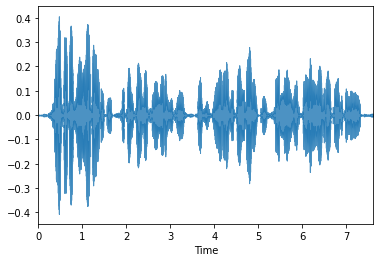

In [170]:
librosa.display.waveplot(audio, sr, alpha=.8)

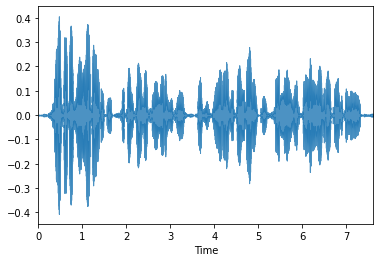

In [171]:
librosa.display.waveplot(audio, sr, alpha=.8)